# Tutorial - interatomic potential

This Tutorial shows how to fit a kQEq interatomic potential on ZnO nanoparticles. 

In [6]:
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt

from kqeq.kernel import SOAPKernel # SOAP kernel class with normalized SOAP descriptos
from kqeq.kQEq import kernel_qeq # kQEq class function
from kqeq.funct import get_energies_perAtom, get_energies # help functions for obtaining values from extended xyz
from kqeq.funct import plot_basics # help function for plotting simple graphs in 1 line

We start by loading a training and test set. We are using minima structures from the example for ZnO interatomic potential. For the time reason, we are loading only small part of the dataset. This won't be properly sufficient to train proper model however.  

In [7]:
mols = read("../examples/ZnOParticles/particles.xyz@:40",format='extxyz')
train_set = mols[:30]
test_set = mols[30:]

Here, we are setting up energy of atoms in vacuum, and hardness parameters $J_i$ from the equation
$$ E_\mathrm{tot} \approx E_0 + E_{\mathrm{QEq}}=E_0+\underbrace{\sum_{i=1}^N \left( \chi_i q_i + \frac{1}{2} J_i q_i^2 \right)}_{\mathrm{Site-Energy}} + \underbrace{\frac{1}{2} \iint \frac{\delta \rho(\mathbf{r}) \delta \rho(\mathbf{r'})}{|\mathbf{r}-\mathbf{r'}|}d\mathbf{r}d\mathbf{r'}}_{\mathrm{Coulomb-Integral}}$$

In [8]:
atom_energy = {"Zn": -49117.02929728, 
               "O": -2041.3604}

# hardness in a.u. 
hard_lib = {"O": 1, 
            "Zn": 1}

Next, we create instance of the kernel and descriptors. In this case, SOAP from `dscribe` package is used. `desdictSOAP` will describe hyperparameters for SOAP. Into the `SOAPKernel` class, the training set has to be included, tohether with setting full or sparse GPR. Also, with `perEl` keyword, we can choose if elements of the kernel matrix will be zero or nonzero when comparing 2 different elements. With `CURel` keyword, `sparse_count` amount of atomic environments will be selected for each element (if possible).

In [9]:
desdictSOAP = {"nmax": 4,
           "lmax": 3,
           "rcut": 3.0,
           "sigma": 3.0/8,
           "species": ["Zn","O"],
           "periodic": False}


SOAP_Kernel = SOAPKernel(multi_SOAP=False,
                     descriptor_dict=desdictSOAP,
                     training_set=train_set,
                     sparse=True,
                     sparse_method="CURel",
                     sparse_count=500,
                     perEl = False)

Now, the instance of `kQEq` will be created. `kernel_qeq` should be used in the case, when training is going to be done. In the case that model is already pretrained, `kQEq` class should be used. (See examples folder for more details). `scale_atsize` is a global parameter that multply sizes of atoms. Radius of atom is taken from QEq paper (`qeq` keyword), or from `ase` (`rcov`). Howver, we recomend to stick with `qeq` radii. `hard_lib` passes hardness parameters into the model.

In [10]:


# Create an instance of the kQEq class
my_kqeq = kernel_qeq(Kernel=SOAP_Kernel,
                     scale_atsize=1.0/np.sqrt(2),
                     radius_type="qeq",
                     hard_lib=hard_lib)

Now we train the interatomic potential for ZnO particles. First we obtain reference energies for training the model. Next, `trainEnCharge` function is used for training the model. This will be done iteratively, and some info about each iteration will be printed. This can take a minute...

In [11]:

# Energy of the training set
ref_en_train = get_energies(mols=train_set,atom_energy = atom_energy)
my_kqeq.trainEnCharge(atom_energy=atom_energy,
                      charge_keyword="hirshfeld", 
                      lambda_reg = 0.01,
                      lambda_charges = 0.01,
                      lambda_charges_min=0.001,
                      iter_charges = 2)

####################################################################
New RMSE: 1.8282137372256628
Old RMSE: 10000
Bad RMSEs in row: 1
Sample of charges: [ 0.56854333  0.57398315 -0.57598517 -0.57573678  0.57056214  0.57077905
 -0.57458984 -0.57464764 -0.57620453  0.5733333 ]
iteration 0 is done
####################################################################
####################################################################
New RMSE: 0.04656760113753032
Old RMSE: 1.8282137372256628
Bad RMSEs in row: 1
Sample of charges: [ 0.5399312   0.5441749  -0.54568409 -0.54510301  0.54123058  0.54120435
 -0.54381058 -0.54422627 -0.54591757  0.54312631]
iteration 1 is done
####################################################################
####################################################################
New RMSE: 0.004514317520989237
Old RMSE: 0.04656760113753032
Bad RMSEs in row: 1
Sample of charges: [ 0.53919196  0.54337833 -0.54481024 -0.54421647  0.54045038  0.54041198
 -0.54292443 -

`calculate` function can be used for the calculation of results. However, this would calculate forces too, which is computationally demending task. For this reason, we can compute only energy with an `calculateEnergy` function.  

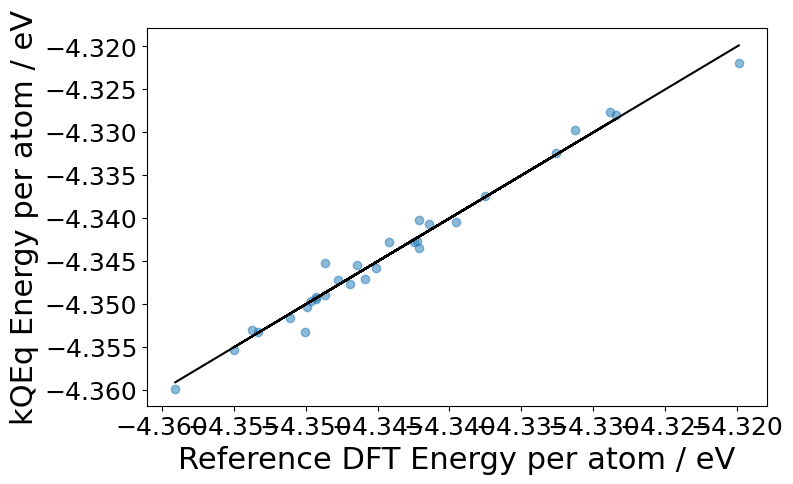

In [12]:
ref_en_train = get_energies_perAtom(mols=train_set,atom_energy = atom_energy)
E_train=[]
for a in train_set:
    E_train.append(my_kqeq.calculateEnergy(a)/len(a))
plot_basics(E_train,ref_en_train,preset="energy")

Finally, we can compute results for the testing set.

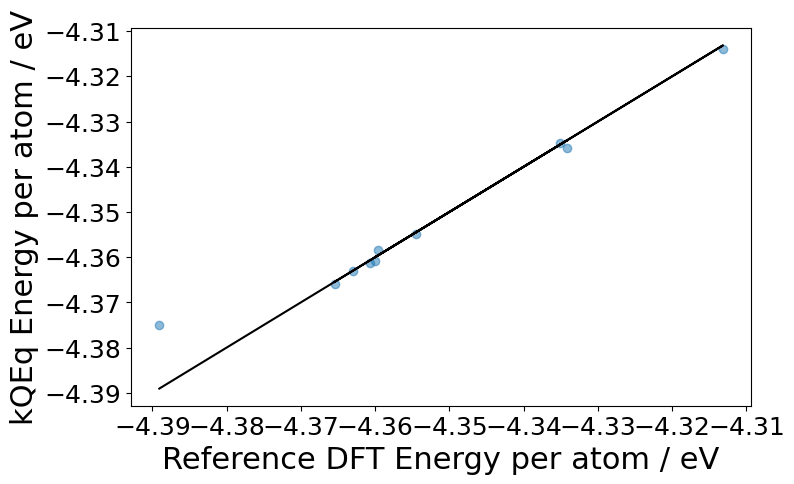

In [14]:
# my_kqeq.save_kQEq()

ref_en_test = get_energies_perAtom(mols=test_set,atom_energy = atom_energy)
E_test=[]
for a in test_set:
    E_test.append(my_kqeq.calculateEnergy(a)/len(a))
plot_basics(E_test,ref_en_test,preset="energy")

In the case when model is trained, it can be saved as `.npy` files with the `save_kQEq` function. 

Save and load function needs 3 input strings values: `nameW` for name of the file for regression weights, `nameS` for file containing SOAP vectors from the representative set, and `nameEl` for the ordered list of elements in the representation set. The same values can be then used for `load_kQEq` function. Default values are `KQEqWeights.npy`,`KQEqSOAP.npy`, `KQEqEl.npy`.

In [15]:
# my_kqeq.save_kQEq(nameW="ZnOtest_Weights.npy",nameS="ZnOtest_SOAP.npy",nameEl="ZnOtest_El.npy")


For `load_kqeq` function, `kQEq` class should be used. Please see `examples` (e.g. QM9 `prediction.py` file) folder for more details. 

In [16]:
# my_kqeq.load_kQEq(nameW="ZnOtest_Weights.npy",nameS="ZnOtest_SOAP.npy",nameEl="ZnOtest_El.npy")
